In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer, ModeClusterer_HDBSCAN  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import get_mpe_data
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files

In [19]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'
data_path = "../../data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
weather_data_path = "../../data/nw2/mvbc_data.parquet"

turbine_data = pd.read_parquet(data_path)
turbine_data = turbine_data.loc[~turbine_data.index.duplicated(keep='first')]
weather_station_data_LAT = pd.read_parquet(weather_data_path)
#rated_data = get_rated_data(data)
#parked_data = get_parked_data(data)

In [20]:
name_location = 'NW2_D01'
mpe_data = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_data[direction] = get_mpe_data(turbine_data, direction, name_location)

In [21]:
mc = {}
clustering_data = {}
clustered_modes = {}
modes = {}

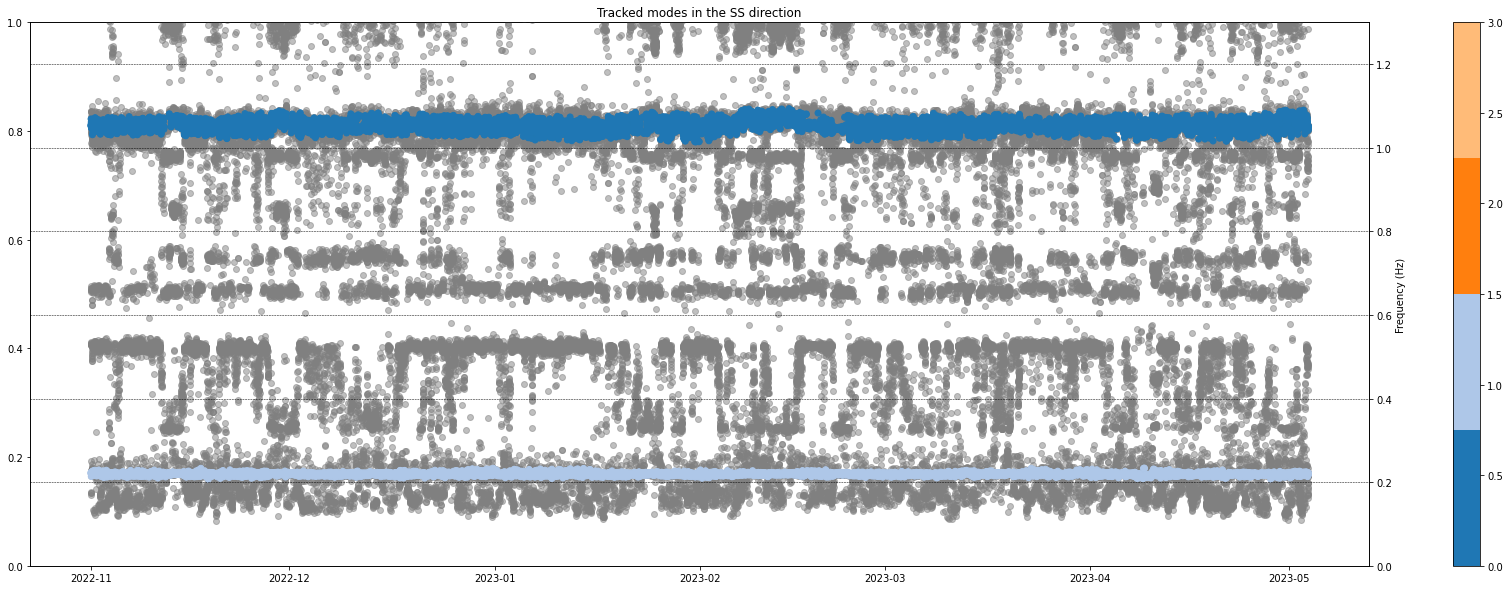

In [22]:
direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 1, "damping": 10},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)

plt.show()

SS1 = clustered_modes[direction][clustered_modes[direction].labels == 1]
SS1 = SS1[~SS1.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2 = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS2 = SS2[~SS2.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

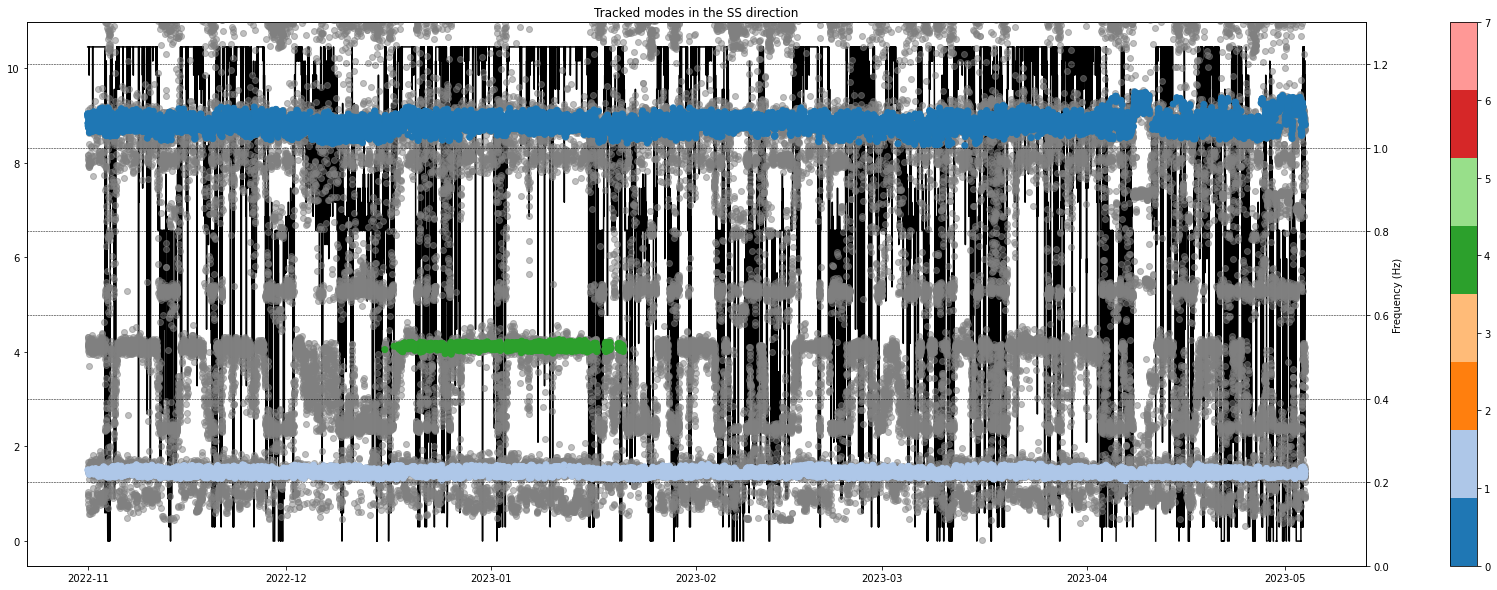

In [23]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 1},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)
plt.show()

FA1 = clustered_modes[direction][clustered_modes[direction].labels == 1]
FA1 = FA1[~FA1.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
FA2 = clustered_modes[direction][clustered_modes[direction].labels == 0]
FA2 = FA2[~FA2.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

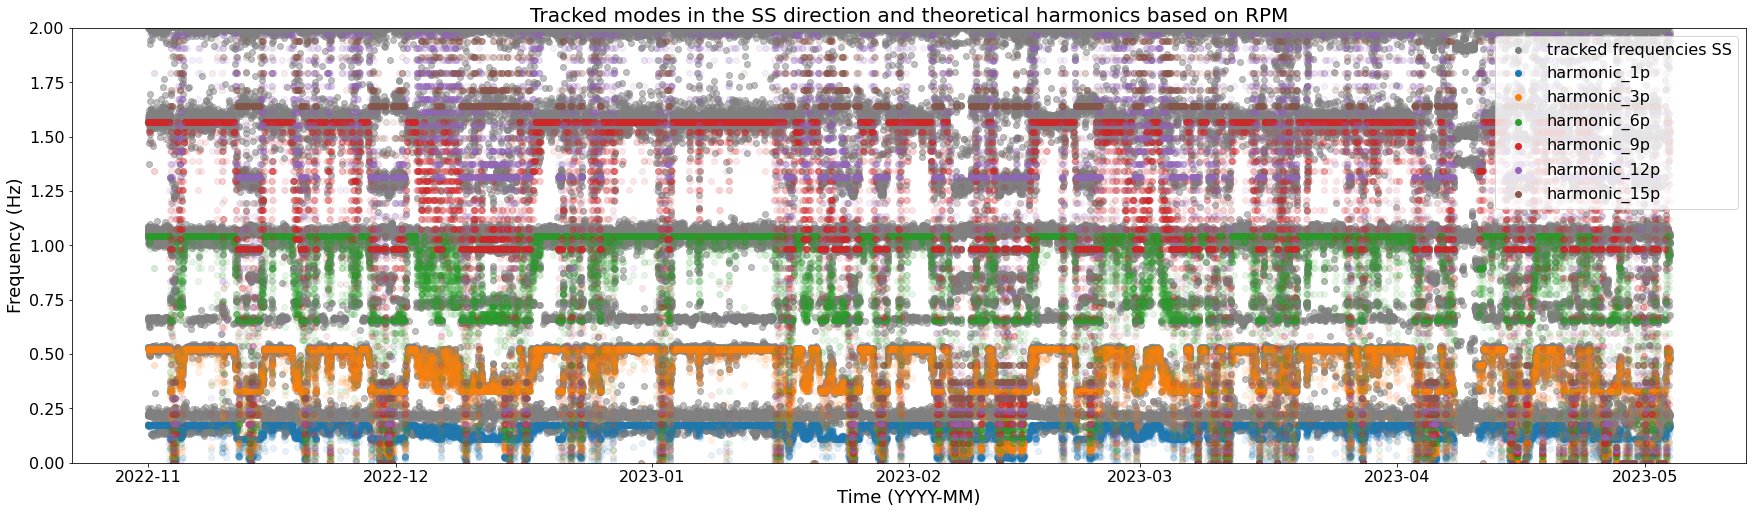

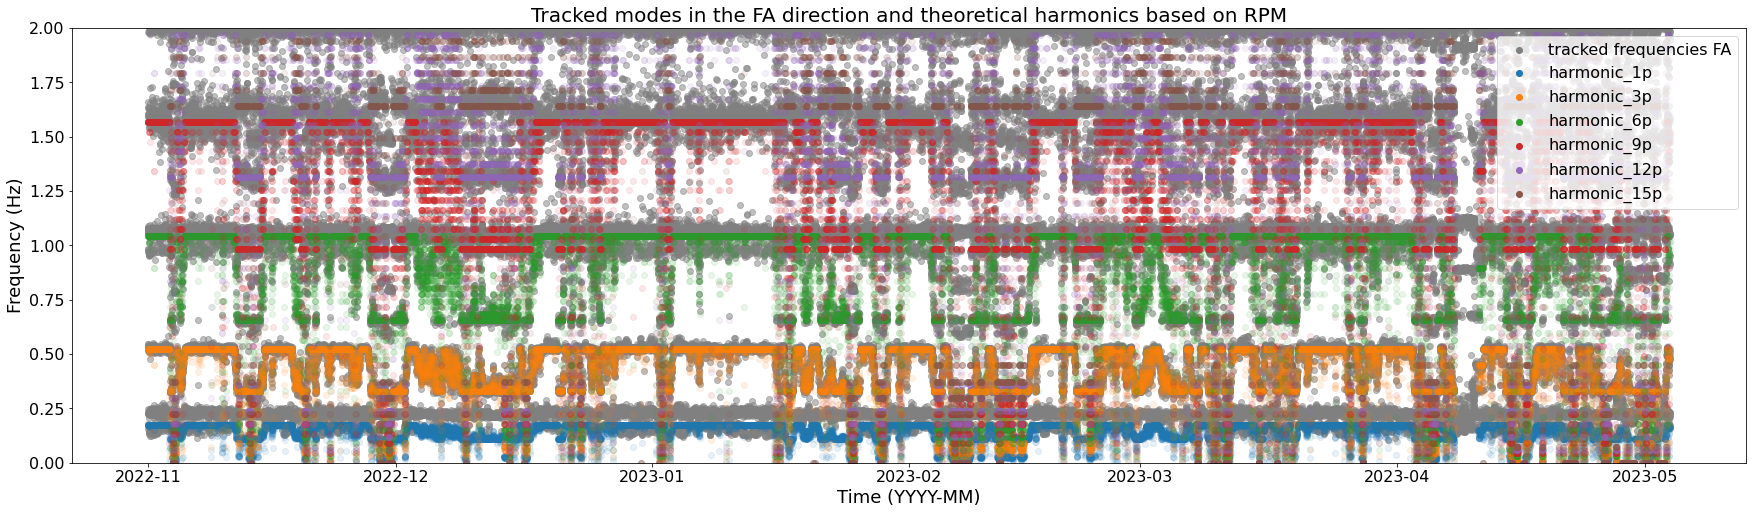

In [24]:
from oma_tracking.modal_tracking.harmonics import theoretical_harmonic
theoretical_harmonics = theoretical_harmonic(turbine_data, p_orders=[1,3,6,9,12,15])

for direction in ['SS', 'FA']:
    plt.figure(figsize = (30,8))
    plt.scatter(clustering_data[direction].index, clustering_data[direction].frequency, c='grey', alpha=0.5, label = 'tracked frequencies ' + direction)
    for col in theoretical_harmonics.columns:
        plt.scatter(theoretical_harmonics[col].index, theoretical_harmonics[col].values, alpha=0.1, label=col)
    plt.ylim(0, 2)
    plt.title('Tracked modes in the ' + direction + ' direction and theoretical harmonics based on RPM', fontsize=20)
    plt.xlabel('Time (YYYY-MM)', fontsize=18)
    plt.ylabel('Frequency (Hz)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    legend = plt.legend(loc='upper right', fontsize=16)
    for handle in legend.legendHandles:
        handle.set_alpha(1.0)
    plt.show()

SS


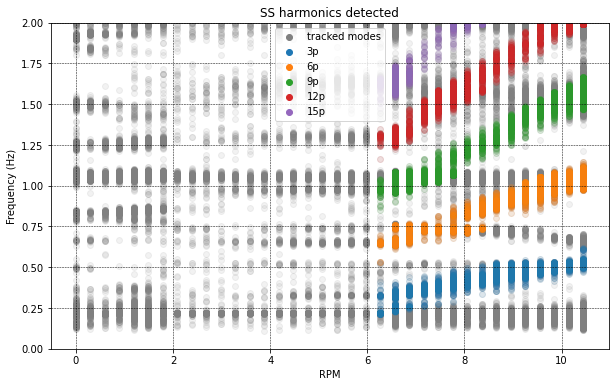

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


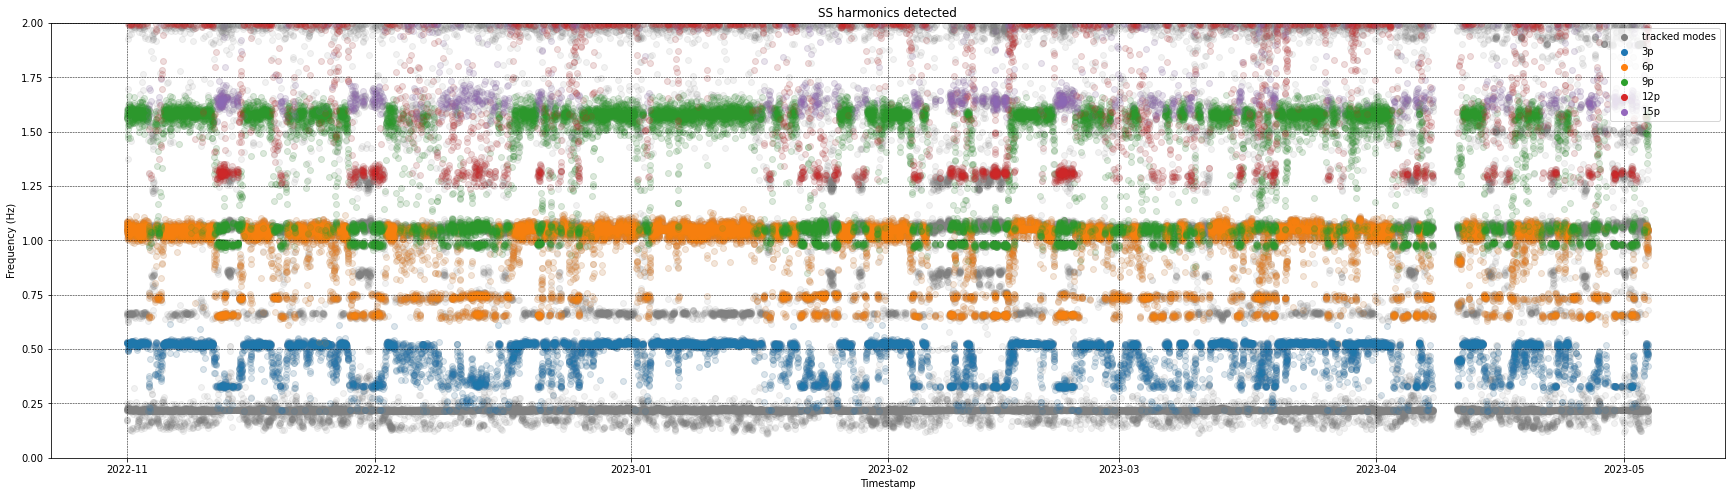

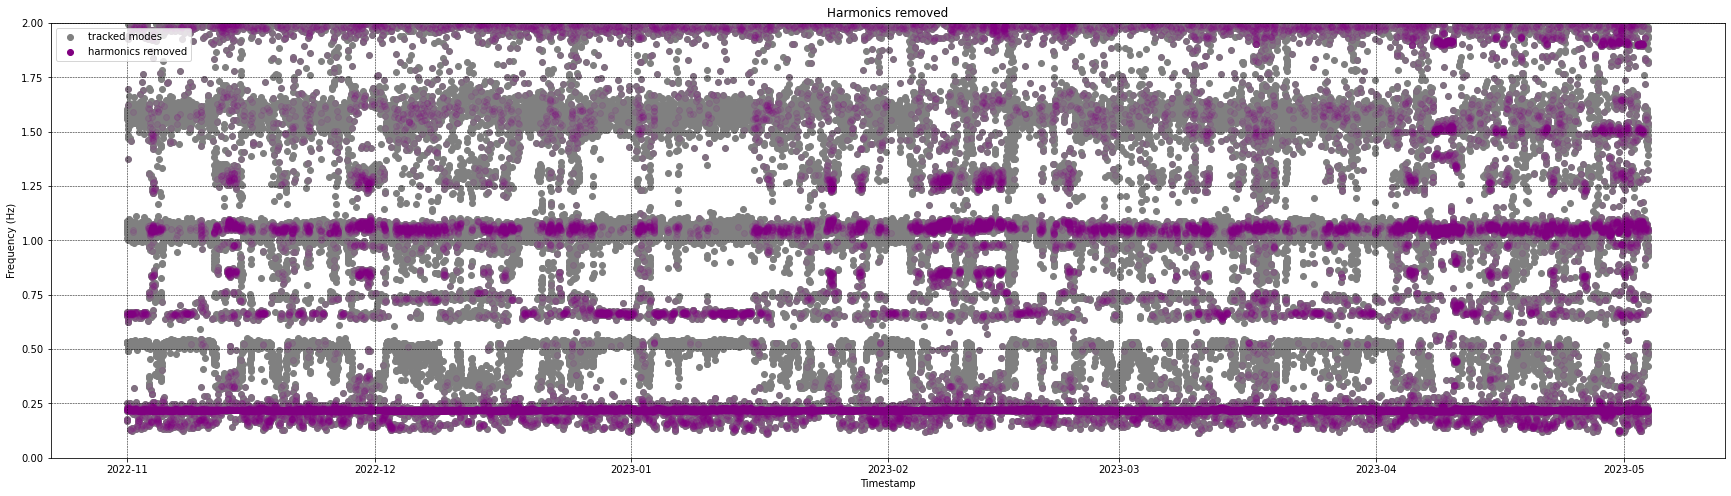

FA


c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


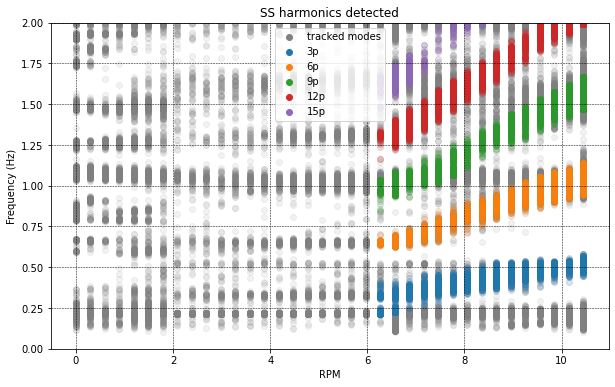

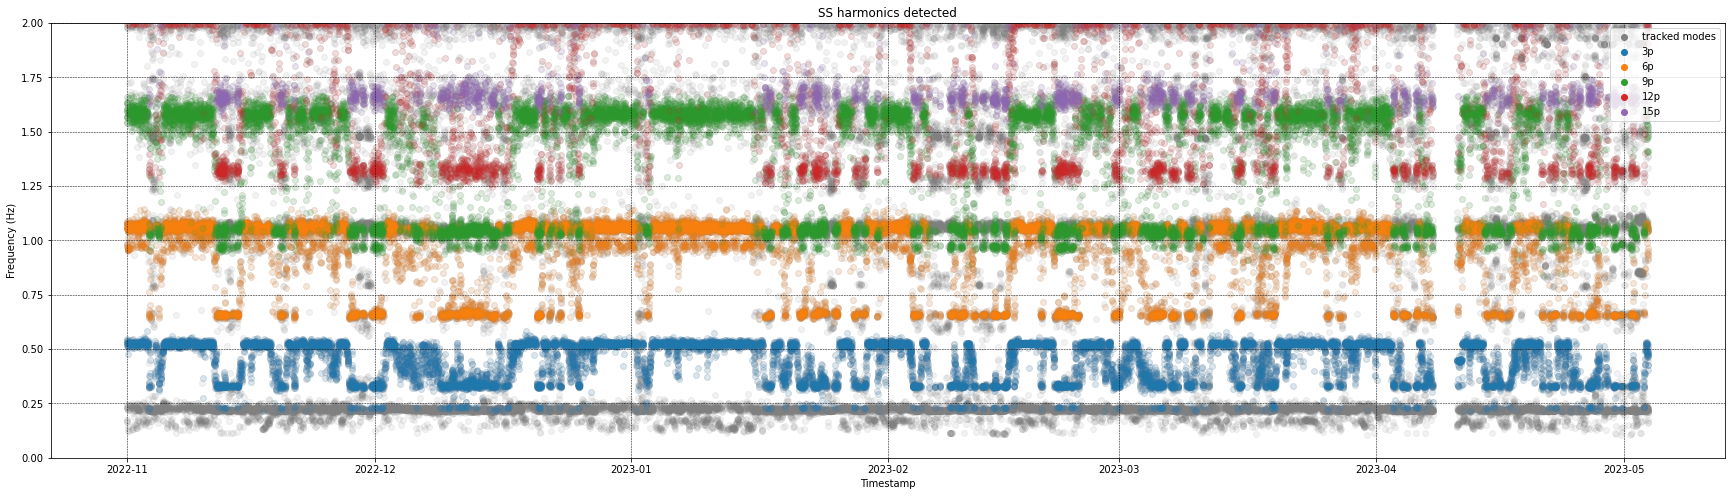

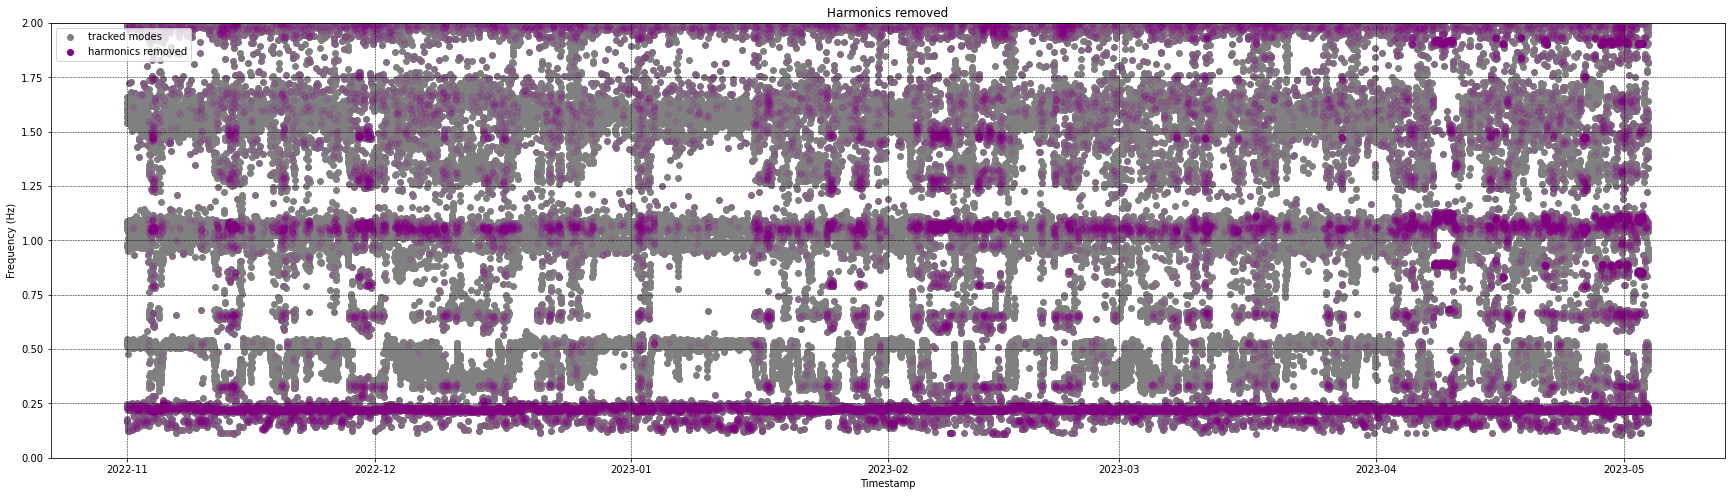

In [9]:
from oma_tracking.modal_tracking.harmonics import HarmonicDetector
harmonic_detectors = {}
harmonics_removed = {}
for direction in ['SS', 'FA']:
    print(direction)
    harmonic_detectors[direction] = HarmonicDetector(turbine_data, clustering_data[direction], p_orders=[3,6,9,12, 15])
    distance_calculator_data = harmonic_detectors[direction].get_distance_calculator_data()
    harmonic_detectors[direction].plot_distances()
    harmonic_detectors[direction].plot_harmonics_removed()
    harmonics_removed[direction] = harmonic_detectors[direction].remove_harmonics()


In [10]:
mpe_data['SS']

algorithm  mean_damping  mean_frequency  size  \
timestamp                                                                 
2022-11-01 00:00:00+00:00      lscf      4.806132        0.220005    30   
2022-11-01 00:00:00+00:00      lscf      3.664014        0.534838    25   
2022-11-01 00:00:00+00:00      lscf      0.521448        1.051824    39   
2022-11-01 00:00:00+00:00      lscf      2.455740        1.086731    31   
2022-11-01 00:00:00+00:00      lscf      2.565565        1.560832    35   
...                             ...           ...             ...   ...   
2023-05-04 00:00:00+00:00      lscf      1.348961        2.696763    41   
2023-05-04 00:00:00+00:00      lscf      0.899155        3.497143    37   
2023-05-04 00:00:00+00:00      lscf      0.325743        3.766517    21   
2023-05-04 00:00:00+00:00      lscf      1.012516        4.172540    37   
2023-05-04 00:00:00+00:00      lscf      0.586188        4.755943    27   

                           std_damping  std_frequency  
timestamp                                              
2022-11-01 00:00:00+00:00     0.285902       0.002627  
2022-11-01 00:00:00+00:00     0.498005       0.002628  
2022-11-01 00:00:00+00:00     0.156326       0.002546  
2022-11-01 00:00:00+00:00     0.158191       0.001997  
2022-11-01 00:00:00+00:00     0.247927       0.003127  
...                                ...            ...  
2023-05-04 00:00:00+00:00     0.104977       0.002477  
2023-05-04 00:00:00+00:00     0.124946       0.004495  
2023-05-04 00:00:00+00:00     0.150600       0.003120  
2023-05-04 00:00:00+00:00     0.166109       0.003750  
2023-05-04 00:00:00+00:00     0.156456       0.004148  

[285178 rows x 6 columns]

In [11]:
harmonics_removed['SS']

algorithm   damping  frequency  size  std_damping  \
timestamp                                                                     
2022-11-01 00:00:00+00:00      lscf  4.806132   0.220005    30     0.285902   
2022-11-01 00:10:00+00:00      lscf  3.460272   0.221963    37     0.273066   
2022-11-01 00:10:00+00:00      lscf  0.980789   0.660464    29     0.420751   
2022-11-01 00:20:00+00:00      lscf  2.032099   0.222790    41     0.379915   
2022-11-01 00:20:00+00:00      lscf  2.301205   0.653708    20     0.289153   
...                             ...       ...        ...   ...          ...   
2023-05-03 23:50:00+00:00      lscf  9.211064   0.182428    38     0.693649   
2023-05-03 23:50:00+00:00      lscf  2.592184   0.222395    40     0.186985   
2023-05-03 23:50:00+00:00      lscf  3.460386   0.680515    17     0.140297   
2023-05-04 00:00:00+00:00      lscf  7.791719   0.170984    19     0.437874   
2023-05-04 00:00:00+00:00      lscf  1.441436   0.219808    42     0.140905   

                           std_frequency  distance_3p  distance_6p  \
timestamp                                                            
2022-11-01 00:00:00+00:00       0.002627     0.302245     0.824495   
2022-11-01 00:10:00+00:00       0.002213     0.300287     0.822537   
2022-11-01 00:10:00+00:00       0.003035     0.138214     0.384036   
2022-11-01 00:20:00+00:00       0.000550     0.299460     0.821710   
2022-11-01 00:20:00+00:00       0.002135     0.131458     0.390792   
...                                  ...          ...          ...   
2023-05-03 23:50:00+00:00       0.001457     0.324872     0.832172   
2023-05-03 23:50:00+00:00       0.000628     0.284905     0.792205   
2023-05-03 23:50:00+00:00       0.002643     0.173215     0.334085   
2023-05-04 00:00:00+00:00       0.000308     0.336316     0.843616   
2023-05-04 00:00:00+00:00       0.001000     0.287492     0.794792   

                           distance_9p  distance_12p  distance_15p  \
timestamp                                                            
2022-11-01 00:00:00+00:00     1.346745      1.868995      2.391245   
2022-11-01 00:10:00+00:00     1.344787      1.867037      2.389287   
2022-11-01 00:10:00+00:00     0.906286      1.428536      1.950786   
2022-11-01 00:20:00+00:00     1.343960      1.866210      2.388460   
2022-11-01 00:20:00+00:00     0.913042      1.435292      1.957542   
...                                ...           ...           ...   
2023-05-03 23:50:00+00:00     1.339472      1.846772      2.354072   
2023-05-03 23:50:00+00:00     1.299505      1.806805      2.314105   
2023-05-03 23:50:00+00:00     0.841385      1.348685      1.855985   
2023-05-04 00:00:00+00:00     1.350916      1.858216      2.365516   
2023-05-04 00:00:00+00:00     1.302092      1.809392      2.316692   

                           mean_NW2_D01_rpm  
timestamp                                    
2022-11-01 00:00:00+00:00            10.445  
2022-11-01 00:10:00+00:00            10.445  
2022-11-01 00:10:00+00:00            10.445  
2022-11-01 00:20:00+00:00            10.445  
2022-11-01 00:20:00+00:00            10.445  
...                                     ...  
2023-05-03 23:50:00+00:00            10.146  
2023-05-03 23:50:00+00:00            10.146  
2023-05-03 23:50:00+00:00            10.146  
2023-05-04 00:00:00+00:00            10.146  
2023-05-04 00:00:00+00:00            10.146  

[52401 rows x 12 columns]

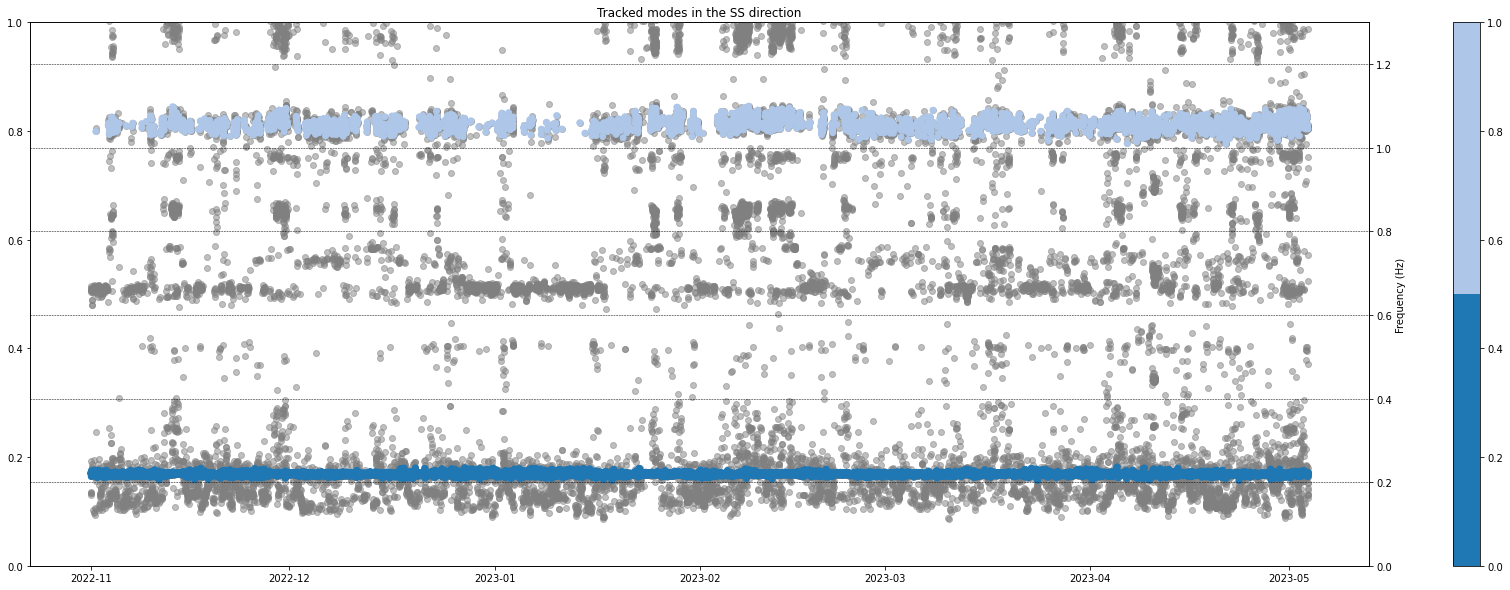

In [25]:
direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=2000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)

plt.show()

SS1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS1_harmonics_removed = SS1_harmonics_removed[~SS1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 3]
SS2_harmonics_removed = SS2_harmonics_removed[~SS2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

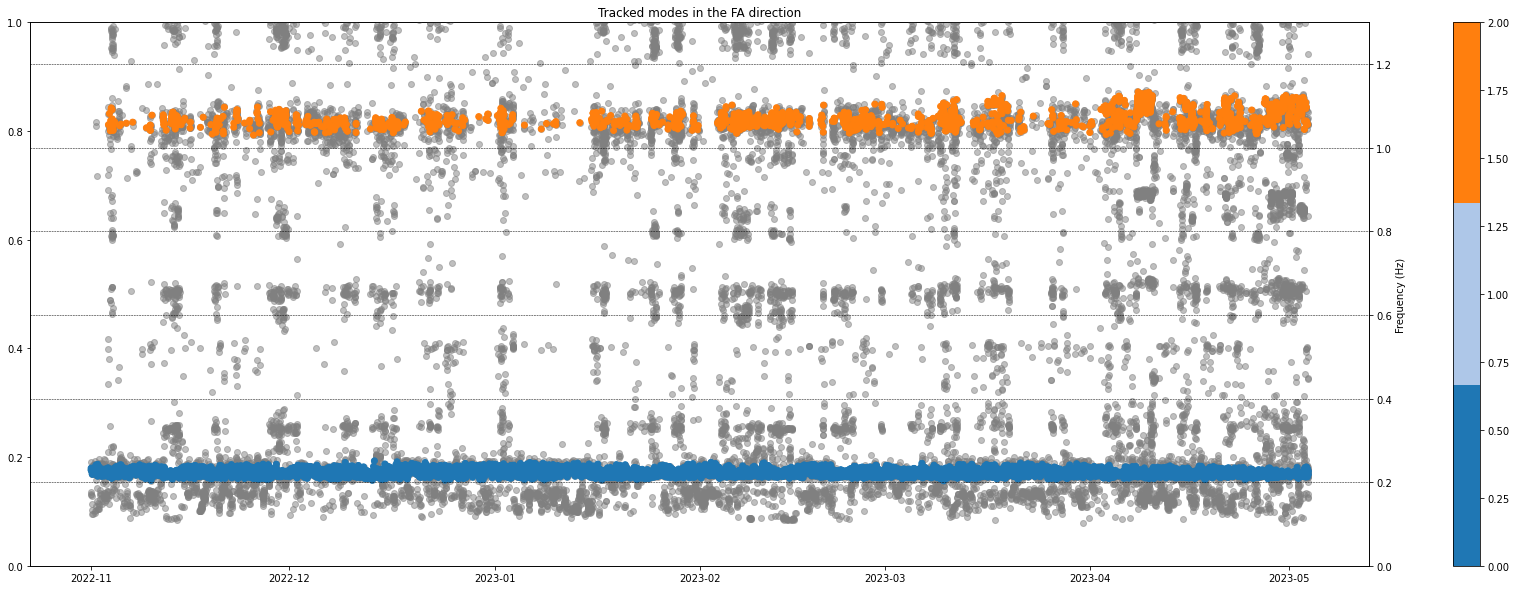

In [13]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the ' + direction + ' direction')
plt.ylim(0, 1.3)

plt.show()

FA1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
FA1_harmonics_removed = FA1_harmonics_removed[~FA1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
FA2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 2]
FA2_harmonics_removed = FA2_harmonics_removed[~FA2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

In [14]:
FA2_harmonics_removed.dropna()

frequency  size   damping  labels
timestamp                                                   
2022-11-03 15:30:00+00:00   1.054927  41.0  3.790812     2.0
2022-11-03 18:50:00+00:00   1.081460  40.0  1.391045     2.0
2022-11-03 22:30:00+00:00   1.040524  40.0  1.377984     2.0
2022-11-03 22:40:00+00:00   1.043331  41.0  1.892900     2.0
2022-11-03 22:50:00+00:00   1.044554  41.0  1.621339     2.0
...                              ...   ...       ...     ...
2023-05-03 16:10:00+00:00   1.057949  41.0  2.348219     2.0
2023-05-03 16:20:00+00:00   1.097541  41.0  1.684636     2.0
2023-05-03 16:30:00+00:00   1.054568  41.0  2.556725     2.0
2023-05-03 18:10:00+00:00   1.061923  39.0  2.813957     2.0
2023-05-03 21:20:00+00:00   1.055533  41.0  2.489052     2.0

[2739 rows x 4 columns]

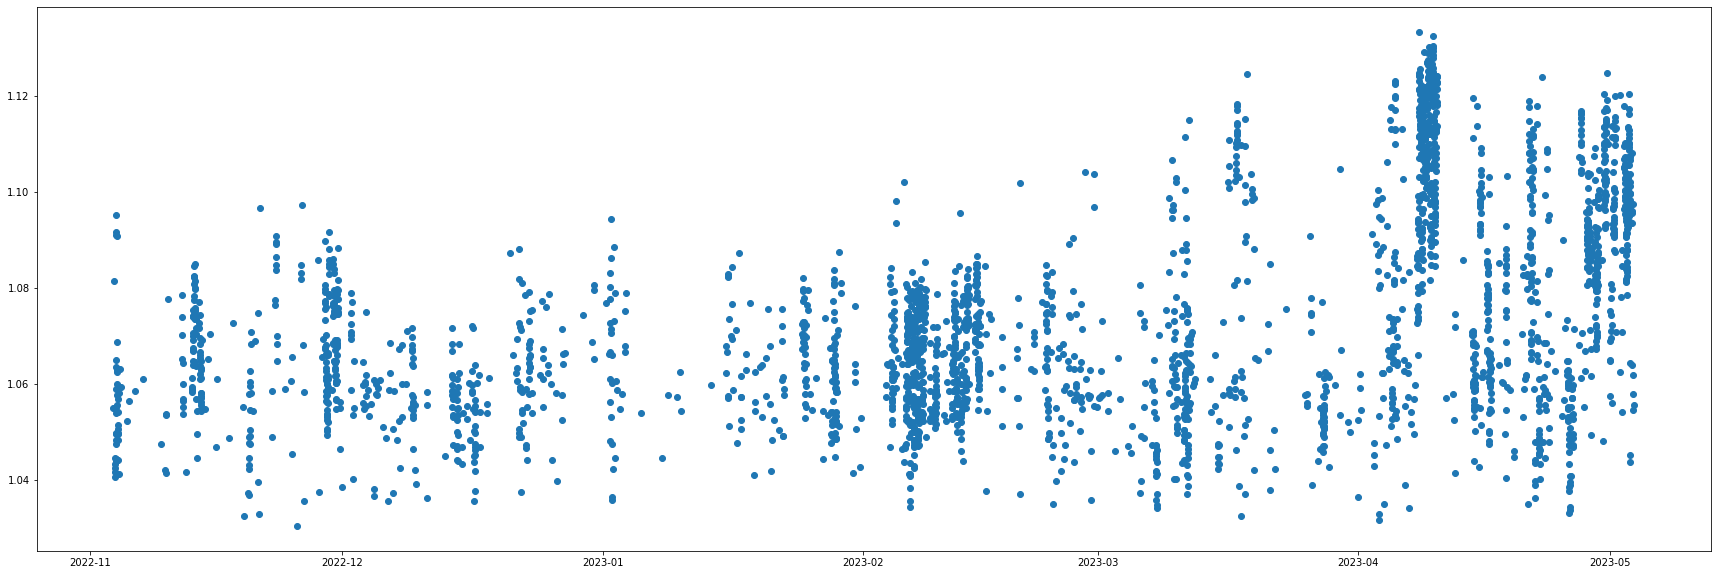

In [15]:
plt.figure(figsize=(30,10))
plt.scatter(FA2_harmonics_removed.index, FA2_harmonics_removed['frequency'], label='FA1')

In [16]:
tracked_frequencies_hamonics_removed = \
    pd.DataFrame(
        {
            'SS1': SS1_harmonics_removed['frequency'],
            'SS2': SS2_harmonics_removed['frequency'],
            'FA1': FA1_harmonics_removed['frequency'],
            'FA2': FA2_harmonics_removed['frequency'],
        }
    )

tracked_frequencies_hamonics_removed.to_parquet('../../data/nw2/tracked_modes/harmonics_removed/' + location + '.parquet', compression='gzip')